Before running this note book please
do the following terminal commands:
apt-get install gcc
pip install pycocotools
conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

#sys.path.insert(1, '//workspace/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *
#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate


#from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

# %load_ext autoreload
# %autoreload 2
# %load_ext autotime


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [3]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [4]:
labeled_scene_index_shuf = labeled_scene_index
random.shuffle(labeled_scene_index_shuf)

train_labeled_scene_index = labeled_scene_index_shuf[:-10]
val_labeled_scene_index = labeled_scene_index_shuf[-10:]


train_labeled_scene_index = labeled_scene_index_shuf[:3]
val_labeled_scene_index = labeled_scene_index_shuf[-3:]

In [5]:
train_labeled_scene_index

array([109, 120, 116])

In [6]:
val_labeled_scene_index

array([130, 118, 133])

In [7]:
# check RCNN dataset
kwargs = {
    #'first_dim': 'sample',
    'transform': transforms.ToTensor(),
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}


dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)

In [8]:
len(dataset_train)

378

In [9]:
train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [10]:
img = None
tg = None
for i ,(image, target) in enumerate(train_data_loader):
    img = image
    tg = target
    #print(img.shape)
    #print(tg.shape)
    break

In [11]:
img

(tensor([[[0.6196, 0.6275, 0.6314,  ..., 1.0000, 0.9961, 0.9961],
          [0.6196, 0.6275, 0.6314,  ..., 1.0000, 0.9961, 0.9961],
          [0.6235, 0.6275, 0.6353,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.3882, 0.3882, 0.3843,  ..., 1.0000, 1.0000, 1.0000],
          [0.3804, 0.3804, 0.3804,  ..., 1.0000, 1.0000, 1.0000],
          [0.3765, 0.3765, 0.3765,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.8235, 0.8314, 0.8353,  ..., 1.0000, 0.9961, 0.9922],
          [0.8235, 0.8314, 0.8353,  ..., 0.9961, 0.9961, 0.9961],
          [0.8275, 0.8314, 0.8392,  ..., 0.9882, 0.9961, 1.0000],
          ...,
          [0.5294, 0.5294, 0.5255,  ..., 1.0000, 1.0000, 1.0000],
          [0.5216, 0.5216, 0.5216,  ..., 1.0000, 1.0000, 1.0000],
          [0.5176, 0.5176, 0.5176,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.9804, 0.9843, 0.9882,  ..., 1.0000, 0.9961, 0.9922],
          [0.9804, 0.9843, 0.9882,  ..., 0.9961, 0.9961, 0.9961],
          [0.9804, 0.9843, 0.9922,  ...,

In [12]:
toImg = transforms.ToPILImage()
img_ = toImg(img[0])

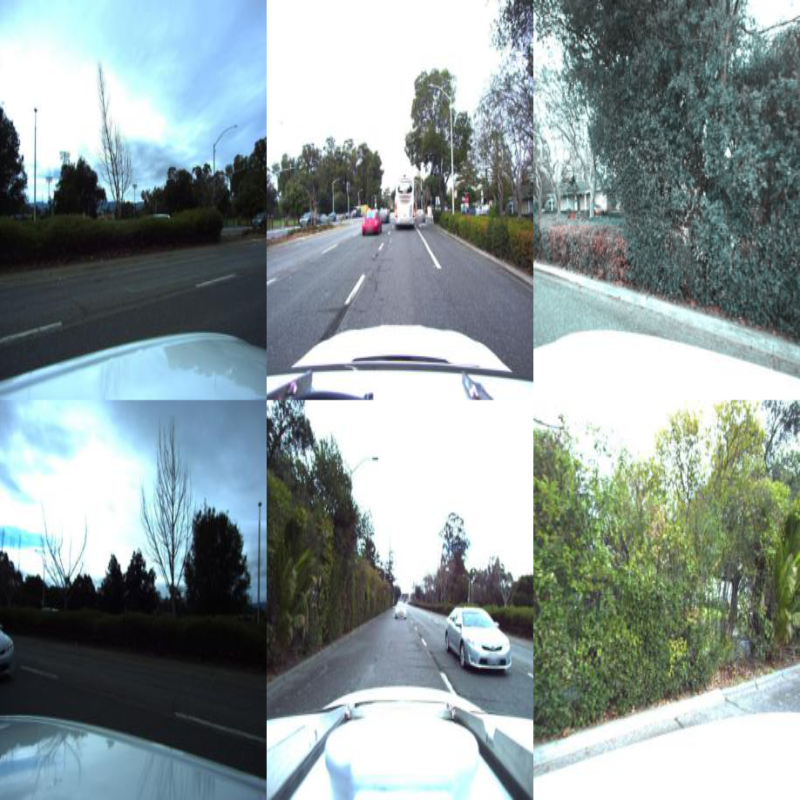

In [13]:
img_

In [14]:
tg ##why is the target all the same?

({'boxes': tensor([[ 605.5192, -447.5290,  645.3287, -428.0957],
          [ 667.5043, -306.1984,  706.7552, -288.3299],
          [ 718.6581, -307.9303,  769.4362, -287.9570],
          [ 527.3635, -609.0549,  574.3232, -589.9675],
          [ 289.3147, -444.0886,  336.8097, -425.0475],
          [  39.7886, -407.5276,   87.6314, -386.2040],
          [ 644.1938, -419.4782,  735.9517, -386.8356],
          [ 158.7540, -566.5718,  205.7137, -547.4843]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 3, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 

In [37]:
tg[0]["masks"].shape

torch.Size([8, 800, 800])

In [35]:
tg[0]["masks"].sum(0).shape

torch.Size([800, 800])

In [38]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.
    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[0], 4], dtype=np.int32)
    for i in range(mask.shape[0]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

In [42]:
[tg[0]["masks"].shape[0],4]

[8, 4]

In [45]:
m = tg[0]["masks"][:, :, 0]

In [47]:
m.shape

torch.Size([8, 800])

In [48]:
np.where(np.any(m.numpy(), axis=0))[0]

array([], dtype=int64)

In [56]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.
    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m.numpy(), axis=0))[0]
        vertical_indicies = np.where(np.any(m.numpy(), axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)




t = extract_bboxes(tg[0]["masks"])

In [15]:
print(len(tg[0]["labels"]))
print(len(tg[0]["iscrowd"]))

8
8


In [16]:
tg[0]["masks"][-1,:,:].sum()

tensor(940.)

In [19]:
tempmasks =  torch.as_tensor(tg[0]["masks"][1,:,:], dtype=torch.uint8).numpy()

In [20]:
type(tempmasks[0][0])

numpy.uint8

In [21]:
tempmasks2 = (tg[0]["masks"][1]).numpy()

In [22]:
type(tempmasks2[0][0])

numpy.float32

In [23]:
torch.tensor([1,2,4])

tensor([1, 2, 4])

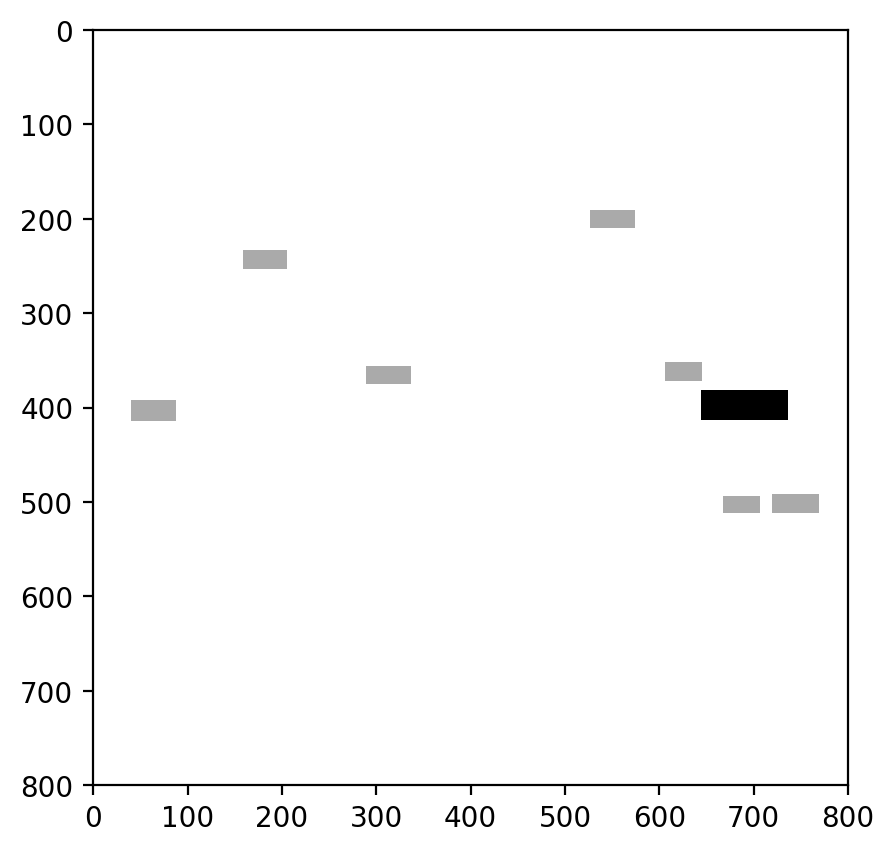

In [17]:
fig, ax = plt.subplots()
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(tg[0]["masks"].sum(0), cmap ='binary');

In [18]:
torch.tensor([109])

tensor([109])

In [19]:
#verify against original labels
from data_helper import UnlabeledDataset, LabeledDataset

tt = transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=tt,
                                  extra_info=True
                                 )
LB_trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [20]:
sample, target, road_image, extra = iter(LB_trainloader).next()

In [21]:
sample_ = sew_images(sample[0])

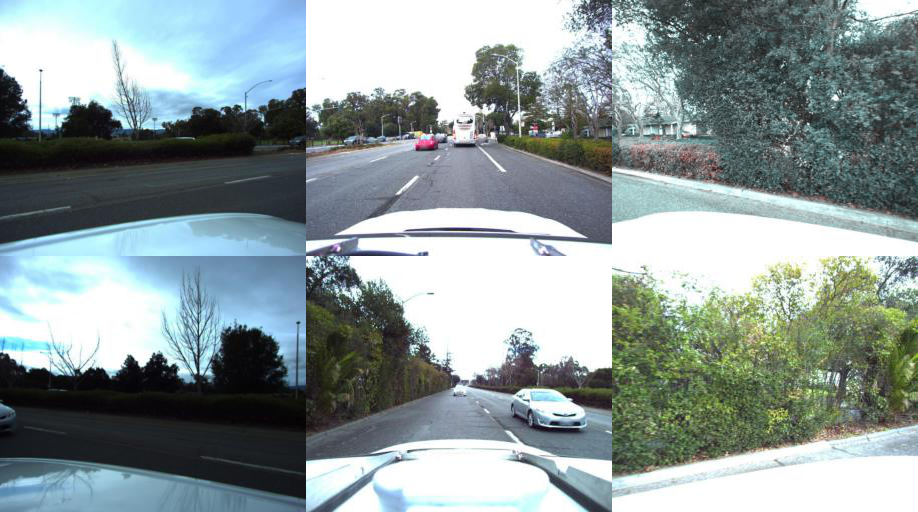

In [22]:
sample_

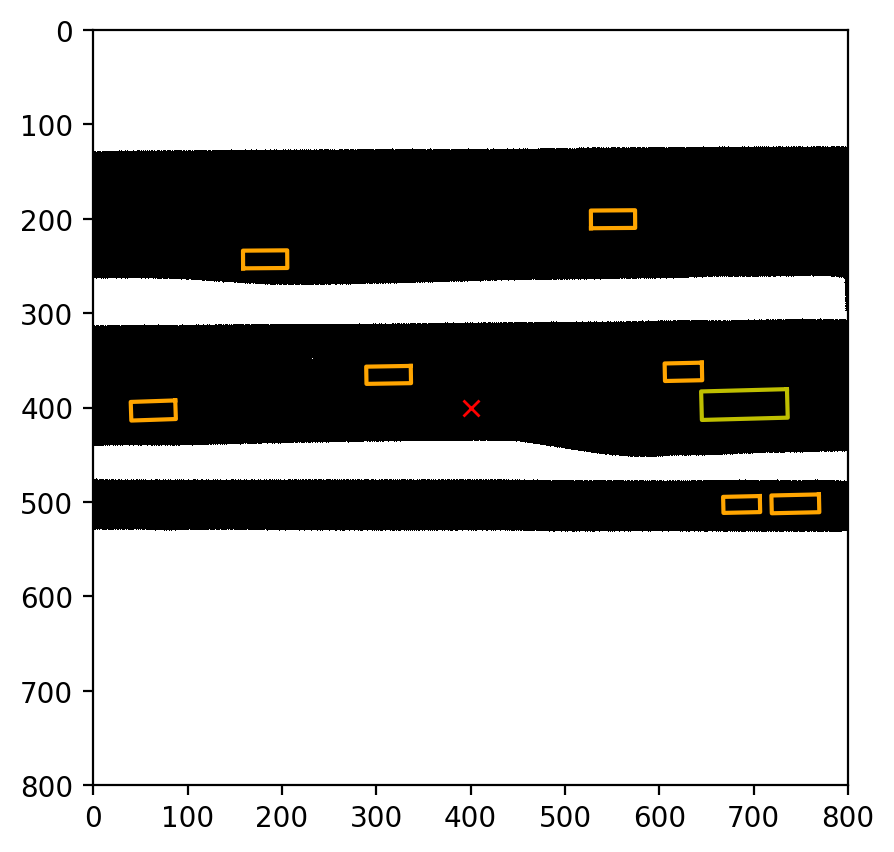

In [23]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.transpose(0,1)[0] * 10 + 400, -point_squence.transpose(0,1)[1] * 10 + 400, color=color)


fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

In [30]:
#the data is correct
#next try to train 1 epoch

time: 479 µs


In [24]:
# !pip3 install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/lexihe/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [25]:


# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 4  # 4 class none, cars, pedestrian, other 4 broke
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

In [26]:
## might need to move this to the helper_RCNN.py
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [27]:
#get train and validation loaders
kwargs = {
    #'first_dim': 'sample',
    'transform': transforms.ToTensor(),
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)

train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [28]:
val_labeled_scene_index

array([130, 118, 133])

In [29]:
len(dataset_val)

378

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 4 #4 returned classifier as nan

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/lexihe/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [31]:
print(len(train_data_loader))
print(len(val_data_loader))

189
378


In [32]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset - this has issues
    #evaluate(model, val_data_loader, device=device)

RuntimeError: No such operator torchvision::nms

In [ ]:
#evaluate(model, val_data_loader, device=device)

In [43]:
#current numpy version is 1.18.1, need to downgrade to 1.17.5
np.__version__

'1.17.5'

time: 2.91 ms


In [ ]:

#downgrading to Numpy 1.17.5 

In [45]:
tt = transforms.ToTensor()
val_labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=tt,
                                  extra_info=True
                                 )
LB_valloader = torch.utils.data.DataLoader(val_labeled_trainset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

time: 176 ms


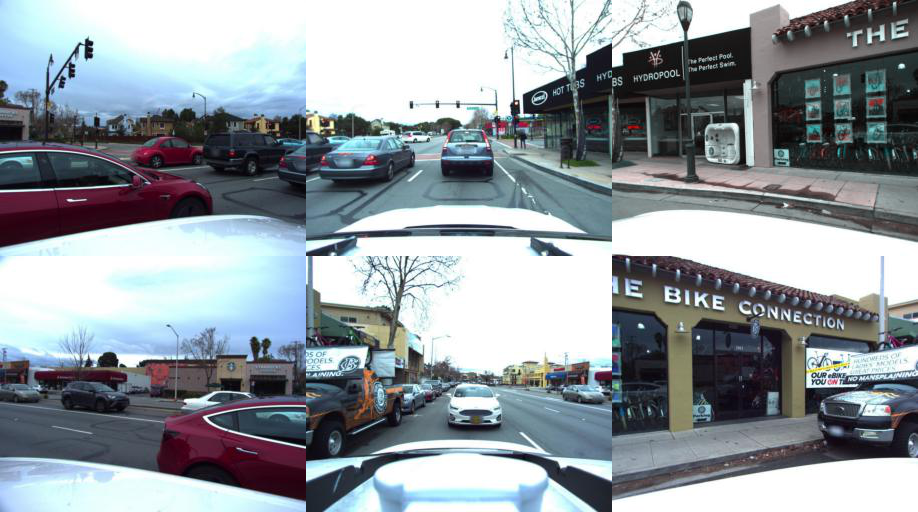

time: 453 ms


In [46]:
sample, target, road_image, extra = iter(LB_valloader).next()
sample_ = sew_images(sample[0])
sample_

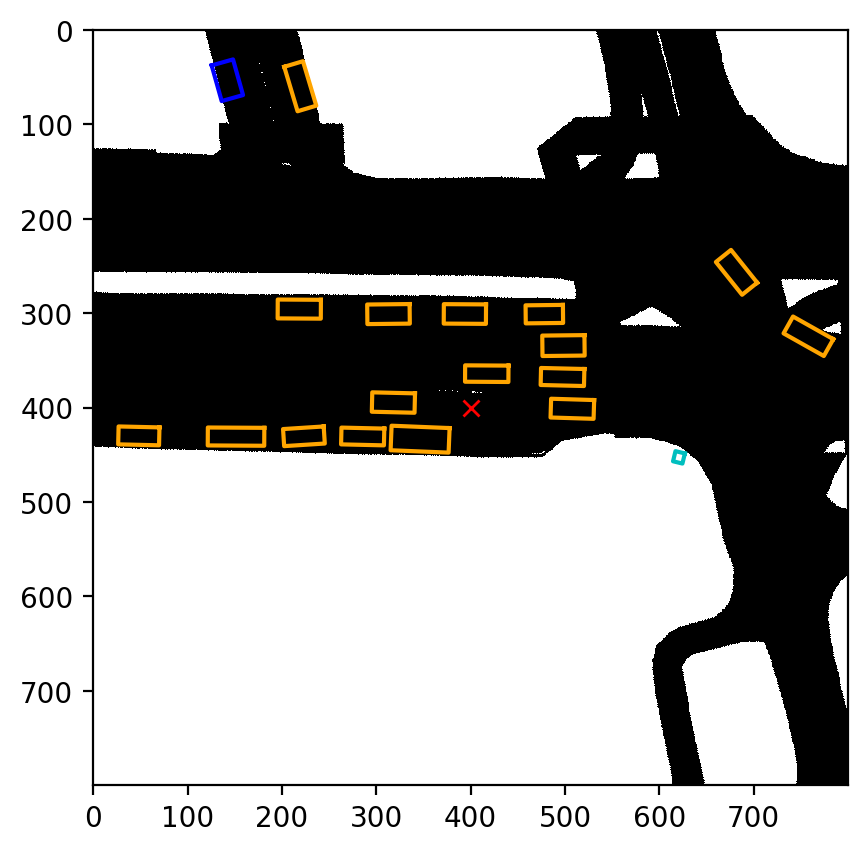

time: 408 ms


In [47]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])
  

In [51]:
#let's check the output of the predictor
img = None
tg = None
for i ,(image, target) in enumerate(val_data_loader):
    img = image
    tg = target

    break

time: 721 ms


In [52]:
img[0].shape

torch.Size([3, 800, 800])

time: 2.23 ms


In [54]:
model.eval()
with torch.no_grad():
    prediction = model([img[0].to(device)])

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

time: 81.1 ms
